# Tweet Intent Classification with Twitter Dataset
<hr>

We will build a intent classification model using GRU model using twitter dataset. The dataset was scrapped using 'Twint'. Since there is no standard train/test split for this dataset, we will use 10-Fold Cross Validation (CV).

<hr>

## Load the library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
from sklearn.model_selection import KFold

In [2]:
## test GPU

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load the dataset

In [4]:
df = pd.read_csv('dataset/tweetlabels1000_labeled.xlsx - Sheet2.csv')

In [5]:
print(df.shape)
df

(1003, 4)


,No,Label,Username,Tweet
0,0,none,chyrisalys,wifi watcha pasti indihome
1,1,indirect complaint,woiidal,indihome ada masalah apasih??!!
2,2,remark,ranieaw,sore sore hujan rebahan bareng bocil nonton nu...
3,3,negative remark,daeguv_,"indihome plis untuk tanggal 10,13 jangan kesur..."
4,4,indirect complaint,fiorincha,INDIHOME NGAPASIIII
...,...,...,...,...
998,998,campaign,sangwarior,Bisa sharing bareng sobat indihome gini kan as...
999,999,campaign,sangwarior,Sekarang nyantai dulu bentar sambil scroll sos...
1000,1000,negative remark,untextend,@JefriHandri Sini indihome down dr semalem jam...
1001,1001,campaign,sangwarior,Ini barusan slesei sob... Lumayan buat nyari k...


In [6]:
# drop rows with label = campaign, own tweet, & incomplete
df = df.loc[~df['Label'].isin(['campaign','own tweet','incomplete'])].copy()
df

,No,Label,Username,Tweet
0,0,none,chyrisalys,wifi watcha pasti indihome
1,1,indirect complaint,woiidal,indihome ada masalah apasih??!!
2,2,remark,ranieaw,sore sore hujan rebahan bareng bocil nonton nu...
3,3,negative remark,daeguv_,"indihome plis untuk tanggal 10,13 jangan kesur..."
4,4,indirect complaint,fiorincha,INDIHOME NGAPASIIII
...,...,...,...,...
994,994,inquiry,pecintamochi,"@IndiHomeCare Min, kalo jatuh tempo pembayaran..."
995,995,inquiry,tetehaisyah51,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl..."
997,997,direct complaint,untextend,@IndiHomeCare @fauzindrianto Dari semalem down...
1000,1000,negative remark,untextend,@JefriHandri Sini indihome down dr semalem jam...


In [7]:
# Label Encoding & drop columns
df['label'] = df['Label'].map({'indirect complaint': 0, 'remark': 1, 'negative remark': 0, 'direct compliment' : 1 , 'direct complaint' : 0, 'none' :2, 'inquiry' : 3})
df.drop(['No', 'Label', 'Username'], axis=1, inplace=True)
df

,Tweet,label
0,wifi watcha pasti indihome,2
1,indihome ada masalah apasih??!!,0
2,sore sore hujan rebahan bareng bocil nonton nu...,1
3,"indihome plis untuk tanggal 10,13 jangan kesur...",0
4,INDIHOME NGAPASIIII,0
...,...,...
994,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",3
995,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",3
997,@IndiHomeCare @fauzindrianto Dari semalem down...,0
1000,@JefriHandri Sini indihome down dr semalem jam...,0


In [8]:
df.info()
df.groupby( by='label').count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   722 non-null    object
 1   label   722 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 16.9+ KB


,Tweet
label,
0,306
1,217
2,123
3,76


In [9]:
# Separate the tweet and label
tweets, labels = list(df.Tweet), list(df.label)

In [10]:
tweets[123]

'@IndiHomeCare Halo min, wifi indihome LOS dari tadi siang! Ini gimna?? Urgent nih gw mau make!!  https://t.co/WRXvsHaAUJ'

## Data Preprocessing
<hr>

for data preprocessing we will do:
- Lower the letter case
- Cleansing (remove ascii, digits, punctuations, extra whitespaces, urls)
- Normalization Indonesian words
- Stemming 'kata berimbuhan'
- Tokenization

The tokenization process will be handled by __Tokenizer__ class in TensorFlow

<b>For padding sequence purpose, one way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set.</b>

In [11]:
# to lowercase
df['tweet_lower'] = df['Tweet'].str.lower()
df

,Tweet,label,tweet_lower
0,wifi watcha pasti indihome,2,wifi watcha pasti indihome
1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!
2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...
3,"indihome plis untuk tanggal 10,13 jangan kesur...",0,"indihome plis untuk tanggal 10,13 jangan kesur..."
4,INDIHOME NGAPASIIII,0,indihome ngapasiiii
...,...,...,...
994,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",3,"@indihomecare min, kalo jatuh tempo pembayaran..."
995,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",3,"@indihomecare min, 1 indihome tv bisa gak berl..."
997,@IndiHomeCare @fauzindrianto Dari semalem down...,0,@indihomecare @fauzindrianto dari semalem down...
1000,@JefriHandri Sini indihome down dr semalem jam...,0,@jefrihandri sini indihome down dr semalem jam...


In [12]:
# Regex Manipulation for text cleansing
import re
import string

In [13]:
def text_cleansing(text):
    
       
    # remove non ASCII (emoticon, chinese word, etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    
    # remove digits (using regex) -> subtitute
    text = re.sub('\d+', '', text)
    
    # remove punctuation, reference: https://stackoverflow.com/a/34294398
    # text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove whitespace in the beginning and end of sentence
    text = text.strip()
    
    # remove extra whitespace in the middle of sentence (using regex)
    text = re.sub('\s+', ' ', text)
    
    # remove url in tweet (using regex)
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", "", text)
    
    # masking indihome
    text = re.sub(r"@indihome", "xxxindihomexxx", text)
    
    # remove url in tweet (using regex)
    text = re.sub(r"xxxindihomexxx\w+", "xxxindihomexxx", text)
    
    # masking user
    text = re.sub(r"@\w+", "xxxuserxxx", text)
    
    return text

In [14]:
# text_cleansing()
df['tweet_clean'] = df['tweet_lower'].apply(lambda x: text_cleansing(x))
df

,Tweet,label,tweet_lower,tweet_clean
0,wifi watcha pasti indihome,2,wifi watcha pasti indihome,wifi watcha pasti indihome
1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!
2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...
3,"indihome plis untuk tanggal 10,13 jangan kesur...",0,"indihome plis untuk tanggal 10,13 jangan kesur...","indihome plis untuk tanggal , jangan kesurupan?"
4,INDIHOME NGAPASIIII,0,indihome ngapasiiii,indihome ngapasiiii
...,...,...,...,...
994,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",3,"@indihomecare min, kalo jatuh tempo pembayaran...","xxxindihomexxx min, kalo jatuh tempo pembayara..."
995,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",3,"@indihomecare min, 1 indihome tv bisa gak berl...","xxxindihomexxx min, indihome tv bisa gak berla..."
997,@IndiHomeCare @fauzindrianto Dari semalem down...,0,@indihomecare @fauzindrianto dari semalem down...,xxxindihomexxx xxxuserxxx dari semalem down .....
1000,@JefriHandri Sini indihome down dr semalem jam...,0,@jefrihandri sini indihome down dr semalem jam...,xxxuserxxx sini indihome down dr semalem jam a...


In [15]:
print(df['Tweet'][69])
print(df['Tweet'][63])

@bherlindayl @IndiHome  https://t.co/C07nnk5jkk
@IndiHomeCare @IndiHome Mana. Masi lemot


In [16]:
print(df['tweet_clean'][69])
print(df['tweet_clean'][63])

xxxuserxxx xxxindihomexxx 
xxxindihomexxx xxxindihomexxx mana. masi lemot


In [17]:
# importing the module
import json
  
# reading the data from the file
with open('dataset/combined_slang_words.txt') as f:
    data = f.read()
       
# reconstructing the data as a dictionary
data_dict1 = json.loads(data)
  
len(data_dict1)


1018

In [18]:
# normalization indonesian words
normalized_word = pd.read_csv('dataset/new_kamusalay.csv', header=None)
data_dict2 = dict(zip(normalized_word[0], normalized_word[1]))
len(data_dict2)

15166

In [19]:
def normalize_text1(text):
    return ' '.join(data_dict1.get(word, word) for word in text.split())
def normalize_text2(text):
    return ' '.join(data_dict2.get(word, word) for word in text.split())

In [20]:
df['tweet_normalized1'] = df['tweet_clean'].apply(lambda x: normalize_text1(x))
df['tweet_normalized'] = df['tweet_normalized1'].apply(lambda x: normalize_text1(x))
df

,Tweet,label,tweet_lower,tweet_clean,tweet_normalized1,tweet_normalized
0,wifi watcha pasti indihome,2,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome
1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!
2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...
3,"indihome plis untuk tanggal 10,13 jangan kesur...",0,"indihome plis untuk tanggal 10,13 jangan kesur...","indihome plis untuk tanggal , jangan kesurupan?","indihome plis untuk tanggal , jangan kesurupan?","indihome plis untuk tanggal , jangan kesurupan?"
4,INDIHOME NGAPASIIII,0,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii
...,...,...,...,...,...,...
994,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",3,"@indihomecare min, kalo jatuh tempo pembayaran...","xxxindihomexxx min, kalo jatuh tempo pembayara...","xxxindihomexxx min, kalau jatuh tempo pembayar...","xxxindihomexxx min, kalau jatuh tempo pembayar..."
995,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",3,"@indihomecare min, 1 indihome tv bisa gak berl...","xxxindihomexxx min, indihome tv bisa gak berla...","xxxindihomexxx min, indihome tv bisa gak berla...","xxxindihomexxx min, indihome tv bisa gak berla..."
997,@IndiHomeCare @fauzindrianto Dari semalem down...,0,@indihomecare @fauzindrianto dari semalem down...,xxxindihomexxx xxxuserxxx dari semalem down .....,xxxindihomexxx xxxuserxxx dari semalem down .....,xxxindihomexxx xxxuserxxx dari semalem down .....
1000,@JefriHandri Sini indihome down dr semalem jam...,0,@jefrihandri sini indihome down dr semalem jam...,xxxuserxxx sini indihome down dr semalem jam a...,xxxuserxxx sini indihome down dr semalem jam a...,xxxuserxxx sini indihome down dr semalem jam a...


In [21]:
df.insert(0, 'ID', range(0, len(df)))
df

,ID,Tweet,label,tweet_lower,tweet_clean,tweet_normalized1,tweet_normalized
0,0,wifi watcha pasti indihome,2,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome
1,1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!
2,2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...
3,3,"indihome plis untuk tanggal 10,13 jangan kesur...",0,"indihome plis untuk tanggal 10,13 jangan kesur...","indihome plis untuk tanggal , jangan kesurupan?","indihome plis untuk tanggal , jangan kesurupan?","indihome plis untuk tanggal , jangan kesurupan?"
4,4,INDIHOME NGAPASIIII,0,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii
...,...,...,...,...,...,...,...
994,717,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",3,"@indihomecare min, kalo jatuh tempo pembayaran...","xxxindihomexxx min, kalo jatuh tempo pembayara...","xxxindihomexxx min, kalau jatuh tempo pembayar...","xxxindihomexxx min, kalau jatuh tempo pembayar..."
995,718,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",3,"@indihomecare min, 1 indihome tv bisa gak berl...","xxxindihomexxx min, indihome tv bisa gak berla...","xxxindihomexxx min, indihome tv bisa gak berla...","xxxindihomexxx min, indihome tv bisa gak berla..."
997,719,@IndiHomeCare @fauzindrianto Dari semalem down...,0,@indihomecare @fauzindrianto dari semalem down...,xxxindihomexxx xxxuserxxx dari semalem down .....,xxxindihomexxx xxxuserxxx dari semalem down .....,xxxindihomexxx xxxuserxxx dari semalem down .....
1000,720,@JefriHandri Sini indihome down dr semalem jam...,0,@jefrihandri sini indihome down dr semalem jam...,xxxuserxxx sini indihome down dr semalem jam a...,xxxuserxxx sini indihome down dr semalem jam a...,xxxuserxxx sini indihome down dr semalem jam a...


In [22]:
#Using BLEU score to compare the real sentences with the generated ones
import statistics
from nltk.translate.bleu_score import sentence_bleu

scores=[]

for i in range(len(df)):

    reference = df['tweet_normalized'][df['ID']==i]
    candidate = df['tweet_clean'][df['ID']==i]
    print(reference)
    print(candidate)
    scores.append(sentence_bleu(reference, candidate))
    print(scores)

statistics.mean(scores)

0    wifi watcha pasti indihome
Name: tweet_normalized, dtype: object
0    wifi watcha pasti indihome
Name: tweet_clean, dtype: object
[0]
1    indihome ada masalah apasih??!!
Name: tweet_normalized, dtype: object
1    indihome ada masalah apasih??!!
Name: tweet_clean, dtype: object
[0, 0]
2    sore sore hujan rebahan bareng bocil nonton nu...
Name: tweet_normalized, dtype: object
2    sore sore hujan rebahan bareng bocil nonton nu...
Name: tweet_clean, dtype: object
[0, 0, 0]
3    indihome plis untuk tanggal , jangan kesurupan?
Name: tweet_normalized, dtype: object
3    indihome plis untuk tanggal , jangan kesurupan?
Name: tweet_clean, dtype: object
[0, 0, 0, 0]
4    indihome ngapasiiii
Name: tweet_normalized, dtype: object
4    indihome ngapasiiii
Name: tweet_clean, dtype: object
[0, 0, 0, 0, 0]
5    mager day. ? ga masalah sih mager selama masih...
Name: tweet_normalized, dtype: object
5    mager day. ? ga masalah sih mager selama masih...
Name: tweet_clean, dtype: object
[0, 0, 0, 

Name: tweet_normalized, dtype: object
252    dinaikin mbs tp kok gini xxxindihomexxx 
Name: tweet_clean, dtype: object
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
253    xxxindihomexxx mau pergi indihome karena mau p...
Name: tweet_normalized, dtype: object
253    xxxindihomexxx mau cabut indihome karna mau pi...
Name: tweet_clean, dtype: object
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Name: tweet_normalized, dtype: object
383    indihome telkomsel kok lemot anjjj
Name: tweet_clean, dtype: object
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
385    xxxuserxxx xxxuserxxx xxxindihomexxx nah itu d...
N

Name: tweet_normalized, dtype: object
455    ga lengkap juga loh kalau dirumah ga pake indi...
Name: tweet_clean, dtype: object
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Name: tweet_normalized, dtype: object
559    dan terjadi lagi?. halo indihome, ini kok mode...
Name: tweet_clean, dtype: object
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

678    nonton spiderman home-coming dan tayangan holl...
Name: tweet_normalized, dtype: object
678    nonton spiderman home-coming dan tayangan holl...
Name: tweet_clean, dtype: object
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Name: tweet_normalized, dtype: object
869    indihome cimahi selatan 
Name: tweet_clean, dtype: object
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Name: tweet_normalized, dtype: object
948    wifi indihome mati. red los kedip...
Name: tweet_clean, dtype: object
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

0

In [23]:
# df['tweet_normalized']['ID'==0]
df.loc[df['ID'] == 0]['tweet_normalized']

0    wifi watcha pasti indihome
Name: tweet_normalized, dtype: object

In [24]:
# stemming 'kata berimbuhan'
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [25]:
df['tweet_stemmed'] = df['tweet_normalized'].apply(lambda x: stemmer.stem(x))
df

,ID,Tweet,label,tweet_lower,tweet_clean,tweet_normalized1,tweet_normalized,tweet_stemmed
0,0,wifi watcha pasti indihome,2,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome
1,1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!,indihome ada masalah apasih
2,2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebah bareng bocil nonton nuss...
3,3,"indihome plis untuk tanggal 10,13 jangan kesur...",0,"indihome plis untuk tanggal 10,13 jangan kesur...","indihome plis untuk tanggal , jangan kesurupan?","indihome plis untuk tanggal , jangan kesurupan?","indihome plis untuk tanggal , jangan kesurupan?",indihome plis untuk tanggal jangan surup
4,4,INDIHOME NGAPASIIII,0,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii
...,...,...,...,...,...,...,...,...
994,717,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",3,"@indihomecare min, kalo jatuh tempo pembayaran...","xxxindihomexxx min, kalo jatuh tempo pembayara...","xxxindihomexxx min, kalau jatuh tempo pembayar...","xxxindihomexxx min, kalau jatuh tempo pembayar...",xxxindihomexxx min kalau jatuh tempo bayar ind...
995,718,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",3,"@indihomecare min, 1 indihome tv bisa gak berl...","xxxindihomexxx min, indihome tv bisa gak berla...","xxxindihomexxx min, indihome tv bisa gak berla...","xxxindihomexxx min, indihome tv bisa gak berla...",xxxindihomexxx min indihome tv bisa gak langga...
997,719,@IndiHomeCare @fauzindrianto Dari semalem down...,0,@indihomecare @fauzindrianto dari semalem down...,xxxindihomexxx xxxuserxxx dari semalem down .....,xxxindihomexxx xxxuserxxx dari semalem down .....,xxxindihomexxx xxxuserxxx dari semalem down .....,xxxindihomexxx xxxuserxxx dari semalem down ga...
1000,720,@JefriHandri Sini indihome down dr semalem jam...,0,@jefrihandri sini indihome down dr semalem jam...,xxxuserxxx sini indihome down dr semalem jam a...,xxxuserxxx sini indihome down dr semalem jam a...,xxxuserxxx sini indihome down dr semalem jam a...,xxxuserxxx sini indihome down dr semalem jam a...


## Exploratory Data Analysis (EDA)
Before we fit the clean data to the model, let's explore insights from the data we have.

In [26]:
from collections import Counter

# function to count unique words
def counter_word(text):
    count = Counter()
    for sentence in text.values:
        for word in sentence.split():
            count[word] += 1
    return count

In [27]:
# find out how many unique words in our data
unique_words = counter_word(df['tweet_stemmed'])
len(unique_words)

2233

In [28]:
# take a look at the twenty most common words
unique_words.most_common(20)

[('indihome', 615),
 ('xxxindihomexxx', 320),
 ('xxxuserxxx', 318),
 ('ini', 168),
 ('di', 146),
 ('saya', 143),
 ('yang', 142),
 ('kalau', 102),
 ('sudah', 95),
 ('pakai', 95),
 ('dan', 88),
 ('ada', 85),
 ('banget', 84),
 ('bisa', 81),
 ('lagi', 76),
 ('hari', 69),
 ('saja', 67),
 ('ga', 66),
 ('tidak', 66),
 ('juga', 62)]

In [29]:
# create a frequency table of word frequency
freq = [freq for word, freq in unique_words.items()]
top_unique=max(pd.Series(freq).value_counts())
top_unique

1292

In [30]:
# your code here
sentence_length = df['tweet_stemmed'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='tweet_stemmed', ylabel='Count'>

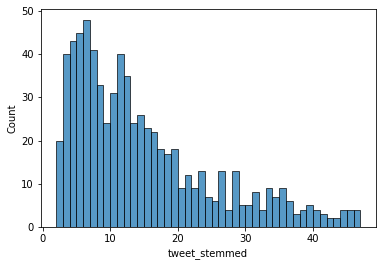

In [31]:
# seaborn
sns.histplot(sentence_length, binwidth=1)

In [32]:
# five number summary
sentence_length.describe()

count    722.000000
mean      14.344875
std       10.490940
min        2.000000
25%        6.000000
50%       11.000000
75%       19.000000
max       47.000000
Name: tweet_stemmed, dtype: float64

In [33]:
# define number of words to keep during conversion (can be tuned)
num_words = len(unique_words)-top_unique
num_words

941


## Bidirectional GRU Model with Random Embedding

In [34]:
# Define a function to compute the max length of sequence
def max_length(sequences):
    '''
    input:
        sequences: a 2D list of integer sequences
    output:
        max_length: the max length of the sequences
    '''
    max_length = 0
    for i, seq in enumerate(sequences):
        length = len(seq)
        if max_length < length:
            max_length = length
    return max_length

In [38]:
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm

def define_model(input_dim = None, output_dim=300, max_length = None ):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=input_dim, 
                                  mask_zero= True,
                                  output_dim=output_dim, 
                                  input_length=max_length, 
                                  input_shape=(max_length, )),
        tf.keras.layers.Bidirectional((tf.keras.layers.GRU(units=64, return_sequences=True))),
        tf.keras.layers.Bidirectional((tf.keras.layers.GRU(units=64, return_sequences=False))),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=4, activation='sigmoid')
    ])
    
    model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [39]:
class myCallback(tf.keras.callbacks.Callback):
    # Overide the method on_epoch_end() for our benefit
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training=True


callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=10, verbose=2, 
                                             mode='auto', restore_best_weights=True)

## Train and Test the model Using 10-Fold cross validation

In [40]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Parameter Initialization
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

columns = ['acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'acc6', 'acc7', 'acc8', 'acc9', 'acc10', 'AVG']
record = pd.DataFrame(columns = columns)

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(n_splits=10, shuffle=False, random_state=None)

# Separate the tweet and label
tweets, labels = list(df.tweet_stemmed), list(df.label)

exp=0

# kfold.split() will return set indices for each split
acc_list = []
for train, test in kfold.split(tweets):
    
    exp+=1
    print('Training {}: '.format(exp))
    
    train_x, test_x = [], []
    train_y, test_y = [], []

    for i in train:
        train_x.append(tweets[i])
        train_y.append(labels[i])

    for i in test:
        test_x.append(tweets[i])
        test_y.append(labels[i])

    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # one-hot
    onehot_train_y = to_categorical(train_y)
    onehot_test_y = to_categorical(test_y)

    # encode data using Cleaning and Tokenization
    tokenizer = Tokenizer(num_words=num_words,oov_token=oov_tok)
    tokenizer.fit_on_texts(train_x)

    # Turn the text into sequence
    training_sequences = tokenizer.texts_to_sequences(train_x)
    test_sequences = tokenizer.texts_to_sequences(test_x)

    max_len = max_length(training_sequences)

    # Pad the sequence to have the same size
    Xtrain = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
    Xtest = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

    word_index = tokenizer.word_index
    vocab_size = len(word_index)+1

    # Define the input shape
    model = define_model(input_dim=vocab_size, max_length=max_len)

    # Train the model
    model.fit(Xtrain, onehot_train_y, batch_size=32, epochs=30, verbose=1, 
              callbacks=[callbacks], validation_data=(Xtest, onehot_test_y))

    # evaluate the model
    loss, acc = model.evaluate(Xtest, onehot_test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))

    acc_list.append(acc*100)

mean_acc = np.array(acc_list).mean()
entries = acc_list + [mean_acc]

temp = pd.DataFrame([entries], columns=columns)
record = record.append(temp, ignore_index=True)
print()
print(record)
print()

Training 1: 
Epoch 1/30
21/21 [==============================] - 18s 221ms/step - loss: 1.2792 - accuracy: 0.4361 - val_loss: 1.1877 - val_accuracy: 0.4247
Epoch 2/30
21/21 [==============================] - 1s 31ms/step - loss: 1.0095 - accuracy: 0.5978 - val_loss: 0.8476 - val_accuracy: 0.6438
Epoch 3/30
21/21 [==============================] - 1s 31ms/step - loss: 0.6665 - accuracy: 0.7257 - val_loss: 0.7527 - val_accuracy: 0.7671
Epoch 4/30
21/21 [==============================] - 1s 30ms/step - loss: 0.3829 - accuracy: 0.8690 - val_loss: 0.9061 - val_accuracy: 0.7534
Epoch 5/30
21/21 [==============================] - 1s 31ms/step - loss: 0.2166 - accuracy: 0.9322 - val_loss: 1.0717 - val_accuracy: 0.7534
Epoch 6/30
21/21 [==============================] - 1s 31ms/step - loss: 0.1542 - accuracy: 0.9507 - val_loss: 1.1808 - val_accuracy: 0.7397
Epoch 7/30
21/21 [==============================] - 1s 30ms/step - loss: 0.1060 - accuracy: 0.9707 - val_loss: 1.2123 - val_accuracy: 0.767

21/21 [==============================] - 1s 31ms/step - loss: 0.1443 - accuracy: 0.9554 - val_loss: 1.9755 - val_accuracy: 0.5139
Epoch 7/30
21/21 [==============================] - 1s 31ms/step - loss: 0.0892 - accuracy: 0.9738 - val_loss: 2.0647 - val_accuracy: 0.5000
Epoch 8/30
21/21 [==============================] - 1s 31ms/step - loss: 0.0667 - accuracy: 0.9754 - val_loss: 2.2535 - val_accuracy: 0.4861
Epoch 9/30
21/21 [==============================] - 1s 31ms/step - loss: 0.0528 - accuracy: 0.9831 - val_loss: 2.4399 - val_accuracy: 0.4722
Epoch 10/30
21/21 [==============================] - 1s 30ms/step - loss: 0.0703 - accuracy: 0.9815 - val_loss: 2.1899 - val_accuracy: 0.5278
Epoch 11/30
21/21 [==============================] - 1s 31ms/step - loss: 0.0511 - accuracy: 0.9877 - val_loss: 2.3782 - val_accuracy: 0.4583
Epoch 12/30
21/21 [==============================] - 1s 31ms/step - loss: 0.0413 - accuracy: 0.9877 - val_loss: 2.5422 - val_accuracy: 0.5000
Epoch 13/30
21/21 [==

21/21 [==============================] - 1s 32ms/step - loss: 0.0607 - accuracy: 0.9800 - val_loss: 1.1424 - val_accuracy: 0.7361
Epoch 12/30
21/21 [==============================] - 1s 30ms/step - loss: 0.0596 - accuracy: 0.9800 - val_loss: 1.0811 - val_accuracy: 0.7083
Epoch 13/30
21/21 [==============================] - 1s 32ms/step - loss: 0.0504 - accuracy: 0.9785 - val_loss: 1.1995 - val_accuracy: 0.7083
Epoch 00013: early stopping
Test Accuracy: 75.0
Training 8: 
Epoch 1/30
21/21 [==============================] - 16s 229ms/step - loss: 1.2894 - accuracy: 0.4262 - val_loss: 1.0666 - val_accuracy: 0.5833
Epoch 2/30
21/21 [==============================] - 1s 33ms/step - loss: 1.0035 - accuracy: 0.6169 - val_loss: 0.7846 - val_accuracy: 0.6806
Epoch 3/30
21/21 [==============================] - 1s 32ms/step - loss: 0.6238 - accuracy: 0.7462 - val_loss: 0.7696 - val_accuracy: 0.7361
Epoch 4/30
21/21 [==============================] - 1s 31ms/step - loss: 0.3713 - accuracy: 0.8754 -

C:\Users\baktistr\AppData\Local\Temp\ipykernel_53048\2141468724.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record = record.append(temp, ignore_index=True)


In [41]:
record

,acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8,acc9,acc10,AVG
0,79.452056,67.123288,70.833331,52.777779,69.444442,77.777779,75.0,75.0,61.11111,63.88889,69.240867


report = record
report = report.to_excel('GRU.xlsx', sheet_name='random')

## Predict new tweet

In [42]:
# define the preprocessing pipeline
def text_preprocessing(text):
    # case folding
    text = text.lower()
    
    # text cleansing
    text = text_cleansing(text)
    
    # text normalization
    text = normalize_text1(text)
    
     # text normalization
    text = normalize_text2(text)
    
    # stemming
    text = stemmer.stem(text)
    
    return text

In [43]:
# predicting a text
from keras.utils.np_utils import to_categorical

def text_predict(text):
    
    # preprocess
    text_cleaned = text_preprocessing(text)
    text_sequence = tokenizer.texts_to_sequences([text_cleaned])

    max_len= max_length(training_sequences)

    seq_padded = pad_sequences(text_sequence, maxlen=max_len, padding=padding_type, truncating=trunc_type)

    # prediction
    pred_proba = model.predict(seq_padded)

    result = np.argmax(pred_proba)

    return result

In [44]:
# predicting data set

df['tweet_predict'] = df['tweet_stemmed'].apply(lambda x: text_predict(x))
df


,ID,Tweet,label,tweet_lower,tweet_clean,tweet_normalized1,tweet_normalized,tweet_stemmed,tweet_predict
0,0,wifi watcha pasti indihome,2,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome,0
1,1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!,indihome ada masalah apasih??!!,indihome ada masalah apasih,0
2,2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebah bareng bocil nonton nuss...,1
3,3,"indihome plis untuk tanggal 10,13 jangan kesur...",0,"indihome plis untuk tanggal 10,13 jangan kesur...","indihome plis untuk tanggal , jangan kesurupan?","indihome plis untuk tanggal , jangan kesurupan?","indihome plis untuk tanggal , jangan kesurupan?",indihome plis untuk tanggal jangan surup,0
4,4,INDIHOME NGAPASIIII,0,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii,0
...,...,...,...,...,...,...,...,...,...
994,717,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",3,"@indihomecare min, kalo jatuh tempo pembayaran...","xxxindihomexxx min, kalo jatuh tempo pembayara...","xxxindihomexxx min, kalau jatuh tempo pembayar...","xxxindihomexxx min, kalau jatuh tempo pembayar...",xxxindihomexxx min kalau jatuh tempo bayar ind...,3
995,718,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",3,"@indihomecare min, 1 indihome tv bisa gak berl...","xxxindihomexxx min, indihome tv bisa gak berla...","xxxindihomexxx min, indihome tv bisa gak berla...","xxxindihomexxx min, indihome tv bisa gak berla...",xxxindihomexxx min indihome tv bisa gak langga...,0
997,719,@IndiHomeCare @fauzindrianto Dari semalem down...,0,@indihomecare @fauzindrianto dari semalem down...,xxxindihomexxx xxxuserxxx dari semalem down .....,xxxindihomexxx xxxuserxxx dari semalem down .....,xxxindihomexxx xxxuserxxx dari semalem down .....,xxxindihomexxx xxxuserxxx dari semalem down ga...,2
1000,720,@JefriHandri Sini indihome down dr semalem jam...,0,@jefrihandri sini indihome down dr semalem jam...,xxxuserxxx sini indihome down dr semalem jam a...,xxxuserxxx sini indihome down dr semalem jam a...,xxxuserxxx sini indihome down dr semalem jam a...,xxxuserxxx sini indihome down dr semalem jam a...,2


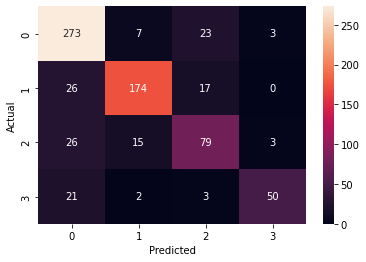

In [50]:
# confusion matrix  
# source: https://datatofish.com/confusion-matrix-python/

confusion_matrix = pd.crosstab(df['label'], df['tweet_predict'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True,fmt='g')
plt.show()

# labels:
        #0: negative / complaint
        #1: postitif / compliment
        #2: inquiry
        #3: none
    